In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [2]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

In [3]:
DATASET_FOLDER = "../input/real-time-anomaly-detection-in-cctv-surveillance/data"

In [4]:
dataset = os.listdir(DATASET_FOLDER)
label_types = os.listdir(DATASET_FOLDER)
print("Class Labels for Videos : ")
label_types.remove('test.csv')
label_types.remove('train.csv')
print(label_types)

Class Labels for Videos : 
['roadaccidents', 'assault', 'vandalism', 'arrest', 'shooting', 'arson', 'explosion', 'normal', 'shoplifting', 'robbery', 'stealing', 'burglary', 'abuse', 'fighting']


## Dataset Analysis

In [5]:
video_counts = []
total = 0
for i in range(len(label_types)):
    videos = len(os.listdir(os.path.join(DATASET_FOLDER, label_types[i])))
    video_counts.append(videos)
    total += videos

print(f"Total videos : {total}")
print(label_types)
print(video_counts)

Total videos : 1900
['roadaccidents', 'assault', 'vandalism', 'arrest', 'shooting', 'arson', 'explosion', 'normal', 'shoplifting', 'robbery', 'stealing', 'burglary', 'abuse', 'fighting']
[150, 50, 50, 50, 50, 50, 50, 950, 50, 150, 100, 100, 50, 50]


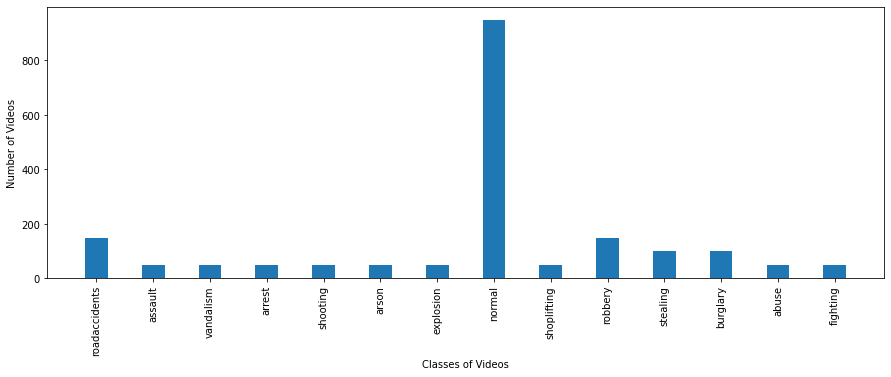

In [6]:
plt.figure(figsize=(15,5))
plt.bar(label_types, video_counts, width=0.4, align="center" )
plt.xticks(rotation=90)

plt.xlabel("Classes of Videos")
plt.ylabel("Number of Videos")
plt.show()

Text(0.5, 1.0, 'Share of Different Types Of Training Videos')

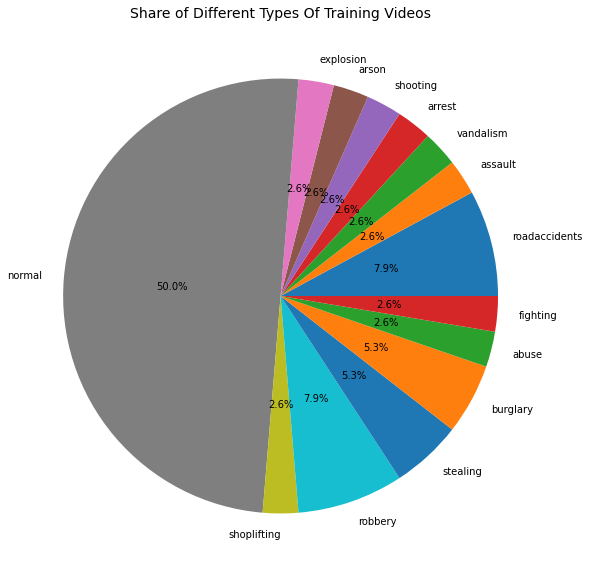

In [7]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(video_counts), autopct="%.1f%%", labels=label_types, pctdistance=0.5)
plt.title("Share of Different Types Of Training Videos", fontsize=14)

## Train and Test Split:

In [8]:
LABEL_COL = "label"
VIDEO_INFO_COL = "video_name"

In [9]:
data = []

for i in range(len(label_types)):
    for video in os.listdir(os.path.join(DATASET_FOLDER, label_types[i])): 
        data.append( (label_types[i] , f"../input/real-time-anomaly-detection-in-cctv-surveillance/data/{label_types[i]}/{video}") )

df = pd.DataFrame(data=data, columns=[ LABEL_COL, VIDEO_INFO_COL])

print(df)

              label                                         video_name
0     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
1     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
2     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
3     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
4     roadaccidents  ../input/real-time-anomaly-detection-in-cctv-s...
...             ...                                                ...
1895       fighting  ../input/real-time-anomaly-detection-in-cctv-s...
1896       fighting  ../input/real-time-anomaly-detection-in-cctv-s...
1897       fighting  ../input/real-time-anomaly-detection-in-cctv-s...
1898       fighting  ../input/real-time-anomaly-detection-in-cctv-s...
1899       fighting  ../input/real-time-anomaly-detection-in-cctv-s...

[1900 rows x 2 columns]


In [10]:
x = df[VIDEO_INFO_COL]
y = df[LABEL_COL]

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train, test = train_test_split(df, test_size = 0.2, stratify=y)

In [13]:
train.value_counts(LABEL_COL)

label
normal           760
roadaccidents    120
robbery          120
burglary          80
stealing          80
abuse             40
arrest            40
arson             40
assault           40
explosion         40
fighting          40
shooting          40
shoplifting       40
vandalism         40
dtype: int64

In [14]:
test.value_counts(LABEL_COL)

label
normal           190
roadaccidents     30
robbery           30
burglary          20
stealing          20
abuse             10
arrest            10
arson             10
assault           10
explosion         10
fighting          10
shooting          10
shoplifting       10
vandalism         10
dtype: int64

Text(0.5, 1.0, 'Share of Training and Testing Videos')

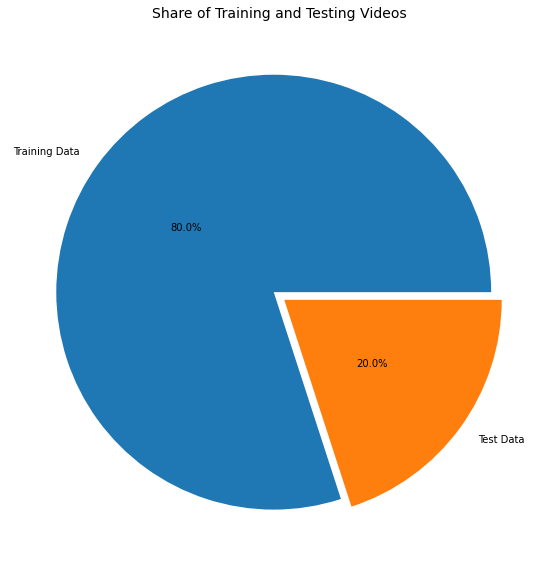

In [15]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([len(train), len(test)]), autopct="%.1f%%", explode=[0.03, 0.03], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of Training and Testing Videos", fontsize=14)

In [16]:
train.to_csv("../working/train.csv")
test.to_csv("../working/test.csv")

### Data Collection :

In [17]:
train_df = pd.read_csv("../working/train.csv")
test_df = pd.read_csv("../working/test.csv")

In [18]:
print(f"Total videos for training : {len(train_df)}")
print(f"Total videos for testing  : {len(test_df)}")

print("Training Dataframe : ")
print(train_df.head(10))

print("Testing Dataset    : ")
print(test_df.head(10))

Total videos for training : 1520
Total videos for testing  : 380
Training Dataframe : 
   Unnamed: 0          label  \
0        1637       stealing   
1        1715       burglary   
2        1876       fighting   
3         237      vandalism   
4         296         arrest   
5        1404    shoplifting   
6        1379         normal   
7         518         normal   
8        1422    shoplifting   
9         124  roadaccidents   

                                          video_name  
0  ../input/real-time-anomaly-detection-in-cctv-s...  
1  ../input/real-time-anomaly-detection-in-cctv-s...  
2  ../input/real-time-anomaly-detection-in-cctv-s...  
3  ../input/real-time-anomaly-detection-in-cctv-s...  
4  ../input/real-time-anomaly-detection-in-cctv-s...  
5  ../input/real-time-anomaly-detection-in-cctv-s...  
6  ../input/real-time-anomaly-detection-in-cctv-s...  
7  ../input/real-time-anomaly-detection-in-cctv-s...  
8  ../input/real-time-anomaly-detection-in-cctv-s...  
9  ../inpu

### Feed the videos to a Network : 

In [19]:
IMG_SIZE = 299

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y,x)
    # print(f"y : {y}      and      x : {x}")
    start_x = (x // 2) -  (min_dim // 2) 
    start_y = (y // 2) -  (min_dim // 2)
    return frame[ start_y : start_y+min_dim, start_x : start_x + min_dim]

In [20]:
def load_video(path, max_frames = 2000, resize = (IMG_SIZE, IMG_SIZE)):

    cap = cv2.VideoCapture(path)
    # allPaths = path.split('/')
    # videoNameAndExt = allPaths[2].split('.')
    # videoName = videoNameAndExt[0] 
    frames = []
    # i = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # if (not os.path.exists('frames/'+videoName)):
            #     os.mkdir('frames/'+videoName)
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2,1,0]]
            # cv2.imwrite('frames/'+ videoName +'/Frame'+ str(i) +'.jpg', frame)
            frames.append(frame)
            # i+=1
            if(len(frames) == max_frames):
                break
    finally:
        cap.release()
    return np.array(frames)

In [21]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [22]:
feature_extractor = build_feature_extractor()

2022-12-26 08:23:01.759838: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [23]:
print(feature_extractor.summary())

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________
None


### Label Encoding
StringLookup layer encode the class labels as integers.

In [24]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["label"]))
print(label_processor.get_vocabulary())

labels = train_df["label"].values
labels = label_processor(labels[..., None]).numpy()
labels

['abuse', 'arrest', 'arson', 'assault', 'burglary', 'explosion', 'fighting', 'normal', 'roadaccidents', 'robbery', 'shooting', 'shoplifting', 'stealing', 'vandalism']


array([[12],
       [ 4],
       [ 6],
       ...,
       [ 7],
       [ 4],
       [ 7]])

<b>Finally, we can put all the pieces together to create our data processing utility.</b>

In [25]:
#Define hyperparameters

IMG_SIZE = 299
BATCH_SIZE = 64
EPOCHS = 30

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [26]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()    
    
    ##take all classlabels from train_df column named 'label' and store in labels
    labels = df["label"].values

    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") 
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") 

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        print(f"Processing video {idx} out of {num_samples}")
        
        frames = load_video(path)
        frames = frames[None, ...]
        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            print(f"\tProcessing frame {i} out of {len(frames)}")
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
train_data, train_labels = prepare_all_videos(train_df)


Processing video 0 out of 1520
	Processing frame 0 out of 1


2022-12-26 08:23:08.633651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Processing video 1 out of 1520
	Processing frame 0 out of 1
Processing video 2 out of 1520
	Processing frame 0 out of 1
Processing video 3 out of 1520
	Processing frame 0 out of 1
Processing video 4 out of 1520
	Processing frame 0 out of 1
Processing video 5 out of 1520
	Processing frame 0 out of 1
Processing video 6 out of 1520
	Processing frame 0 out of 1
Processing video 7 out of 1520
	Processing frame 0 out of 1
Processing video 8 out of 1520
	Processing frame 0 out of 1
Processing video 9 out of 1520
	Processing frame 0 out of 1
Processing video 10 out of 1520
	Processing frame 0 out of 1
Processing video 11 out of 1520
	Processing frame 0 out of 1
Processing video 12 out of 1520
	Processing frame 0 out of 1
Processing video 13 out of 1520
	Processing frame 0 out of 1
Processing video 14 out of 1520
	Processing frame 0 out of 1
Processing video 15 out of 1520
	Processing frame 0 out of 1
Processing video 16 out of 1520
	Processing frame 0 out of 1
Processing video 17 out of 1520
	

In [ ]:
train_data